In [1]:
from pathlib import Path

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import polars as pl

from src.constant import LABELS
from src.preprocess import load_eeg, process_label, calc_weight
from src.visualization import format_time, plot_eeg

plt.style.use("tableau-colorblind10")

In [5]:
data_dir = Path("../../../input/hms-harmful-brain-activity-classification")
list(data_dir.glob("*"))
metadata = pl.read_csv(data_dir / "train.csv")
metadata = process_label(metadata)
metadata = metadata.group_by("eeg_id").agg(
    *[
        pl.col(f"{label}_prob_per_eeg").first().alias(f"{label}_prob")
        for label in LABELS
    ],
    pl.col("weight_per_eeg").first().alias("weight"),
)
display(metadata.head())


def sum_over_labels(labels) -> pl.Expr:
    x = pl.lit(0.0)
    for label in labels:
        x += pl.col(f"pl_{label}_vote")
    return x


df = pl.read_parquet("../data/pseudo_label/eeg022_16ep_sc03c/train_pseudo_label.pqt")
df = (
    df.with_columns(pl.col(f"pl_{label}_vote").exp() for label in LABELS)
    .with_columns(sum_over_labels(LABELS).alias("pl_vote"))
    .with_columns(
        pl.col(f"pl_{label}_vote").truediv(pl.col("pl_vote")).alias(f"pl_{label}_prob")
        for label in LABELS
    )
)


metadata = df.join(metadata, on="eeg_id")
display(metadata.head())

eeg_id,seizure_prob,lpd_prob,gpd_prob,lrda_prob,grda_prob,other_prob,weight
i64,f64,f64,f64,f64,f64,f64,f64
3615299697,0.0,0.0,0.6,0.0,0.0,0.4,0.178571
309647869,0.0,0.5,0.0,0.0,0.0,0.5,0.071429
1156116645,0.0,0.0,0.0,0.333333,0.666667,0.0,0.107143
2284399779,0.0,0.0,0.0,0.0,0.0,1.0,0.071429
3636680416,0.0,0.0,0.0,0.0,0.0,1.0,0.107143


eeg_id,pl_seizure_vote,pl_lpd_vote,pl_gpd_vote,pl_lrda_vote,pl_grda_vote,pl_other_vote,pl_vote,pl_seizure_prob,pl_lpd_prob,pl_gpd_prob,pl_lrda_prob,pl_grda_prob,pl_other_prob,seizure_prob,lpd_prob,gpd_prob,lrda_prob,grda_prob,other_prob,weight
i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64
3615299697,0.01695,0.342121,5.287601,0.100704,1.234458,3.249653,10.231487,0.001657,0.033438,0.516797,0.009843,0.120653,0.317613,0.0,0.0,0.6,0.0,0.0,0.4,0.178571
309647869,0.100507,1.698982,0.06739,0.59793,0.385409,8.510291,11.360508,0.008847,0.149552,0.005932,0.052632,0.033925,0.749112,0.0,0.5,0.0,0.0,0.0,0.5,0.071429
1156116645,0.340094,0.05331,0.12415,1.620257,4.931796,3.327258,10.396864,0.032711,0.005127,0.011941,0.155841,0.474354,0.320025,0.0,0.0,0.0,0.333333,0.666667,0.0,0.107143
2284399779,0.028777,0.431357,0.153855,2.28307,2.638082,4.505092,10.040232,0.002866,0.042963,0.015324,0.227392,0.262751,0.448704,0.0,0.0,0.0,0.0,0.0,1.0,0.071429
3636680416,0.297724,0.127301,0.142989,0.152112,0.223639,18.893198,19.836964,0.015009,0.006417,0.007208,0.007668,0.011274,0.952424,0.0,0.0,0.0,0.0,0.0,1.0,0.107143


pl_seizure_prob,pl_lpd_prob,pl_gpd_prob,pl_lrda_prob,pl_grda_prob,pl_other_prob
f32,f32,f32,f32,f32,f32
0.082457,0.117416,0.098825,0.065964,0.107066,0.528272


pl_seizure_prob,pl_lpd_prob,pl_gpd_prob,pl_lrda_prob,pl_grda_prob,pl_other_prob
f32,f32,f32,f32,f32,f32
0.047198,0.16262,0.123948,0.069372,0.092169,0.504692


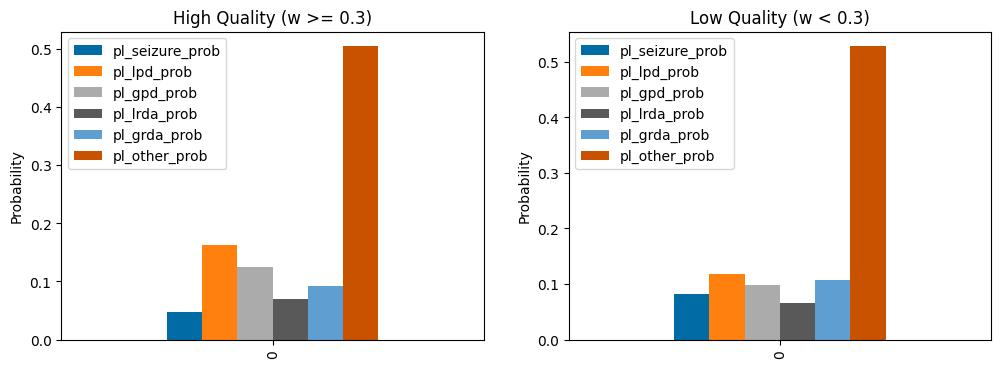

In [6]:

high_quality = metadata.filter(pl.col("weight").ge(0.3)).select(f"pl_{label}_prob" for label in LABELS)
low_quality = metadata.filter(pl.col("weight").lt(0.3)).select(f"pl_{label}_prob" for label in LABELS)

display(low_quality.drop("eeg_id").mean())
display(high_quality.drop("eeg_id").mean())

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
high_quality.drop("eeg_id", "weight").mean().to_pandas().plot.bar(ax=ax1)
low_quality.drop("eeg_id", "weight").mean().to_pandas().plot.bar(ax=ax2)
ax1.set(title="High Quality (w >= 0.3)", ylabel="Probability")
ax2.set(title="Low Quality (w < 0.3)", ylabel="Probability")
plt.show()